In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV

import pandas as pd
df = pd.read_csv("/Users/bastiaanweststrate/Desktop/GSB 544/AmesHousing (1).csv")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [21]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
from plotnine import *

# Load dataset
df = pd.read_csv("AmesHousing.csv")

# Drop high-missing columns and rows with missing data
df = df.loc[:, df.isna().sum() < 100]
df = df.dropna()

# Define X and y
X = df.drop(columns=["SalePrice", "Order", "PID"], errors="ignore")
y = df["SalePrice"]

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
     make_column_selector(dtype_include=object))
])


OLS RMSE: 29730.71
Ridge RMSE (λ=1): 28871.92


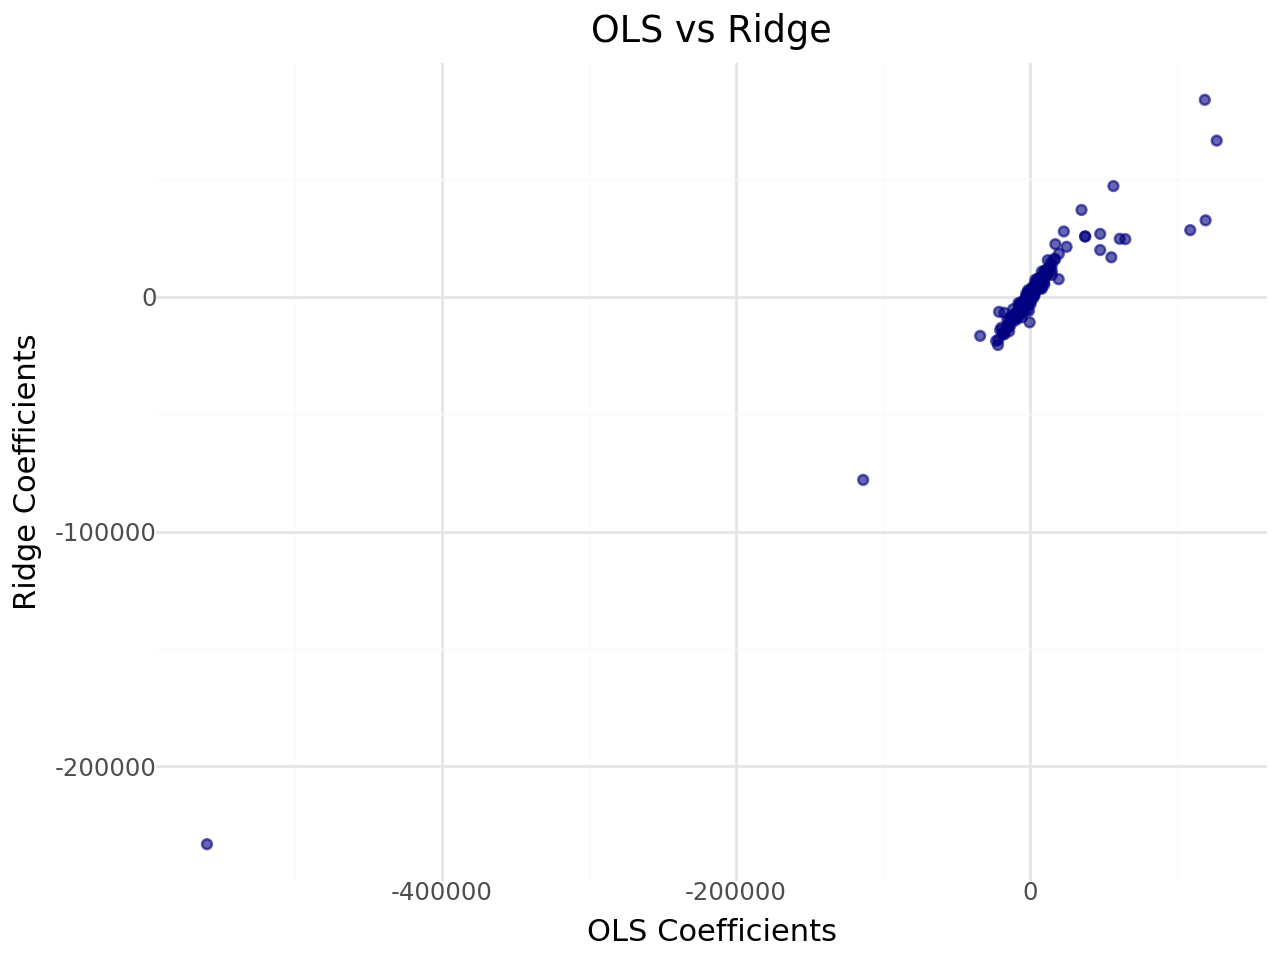

In [23]:
#activity 1
ols_model = Pipeline([
    ("prep", preprocessor),
    ("ols", LinearRegression())
])

ridge_model = Pipeline([
    ("prep", preprocessor),
    ("ridge", Ridge(alpha=1))
])

# Cross-validation
rmse_ols = (-cross_val_score(ols_model, X, y, cv=5, scoring="neg_root_mean_squared_error")).mean()
rmse_ridge = (-cross_val_score(ridge_model, X, y, cv=5, scoring="neg_root_mean_squared_error")).mean()

print("OLS RMSE:", round(rmse_ols, 2))
print("Ridge RMSE (λ=1):", round(rmse_ridge, 2))

# Fit and compare coefficients
ols_model.fit(X, y)
ridge_model.fit(X, y)

b_ols = ols_model.named_steps["ols"].coef_
b_ridge = ridge_model.named_steps["ridge"].coef_

coef_df = pd.DataFrame({"OLS": b_ols, "Ridge": b_ridge})

(ggplot(coef_df, aes(x="OLS", y="Ridge"))
 + geom_point(alpha=0.6, color="navy")
 + labs(title="OLS vs Ridge", x="OLS Coefficients", y="Ridge Coefficients")
 + theme_minimal())


In [24]:
#activity 2
ridge_pipe = Pipeline([
    ("prep", preprocessor),
    ("ridge", Ridge())
])

param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10]}

ridge_cv = GridSearchCV(
    ridge_pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

ridge_cv.fit(X, y)

best_lambda = ridge_cv.best_params_["ridge__alpha"]
best_rmse = -ridge_cv.best_score_

print("Best λ:", best_lambda)
print("Best RMSE:", round(best_rmse, 2))


Best λ: 10
Best RMSE: 28633.51


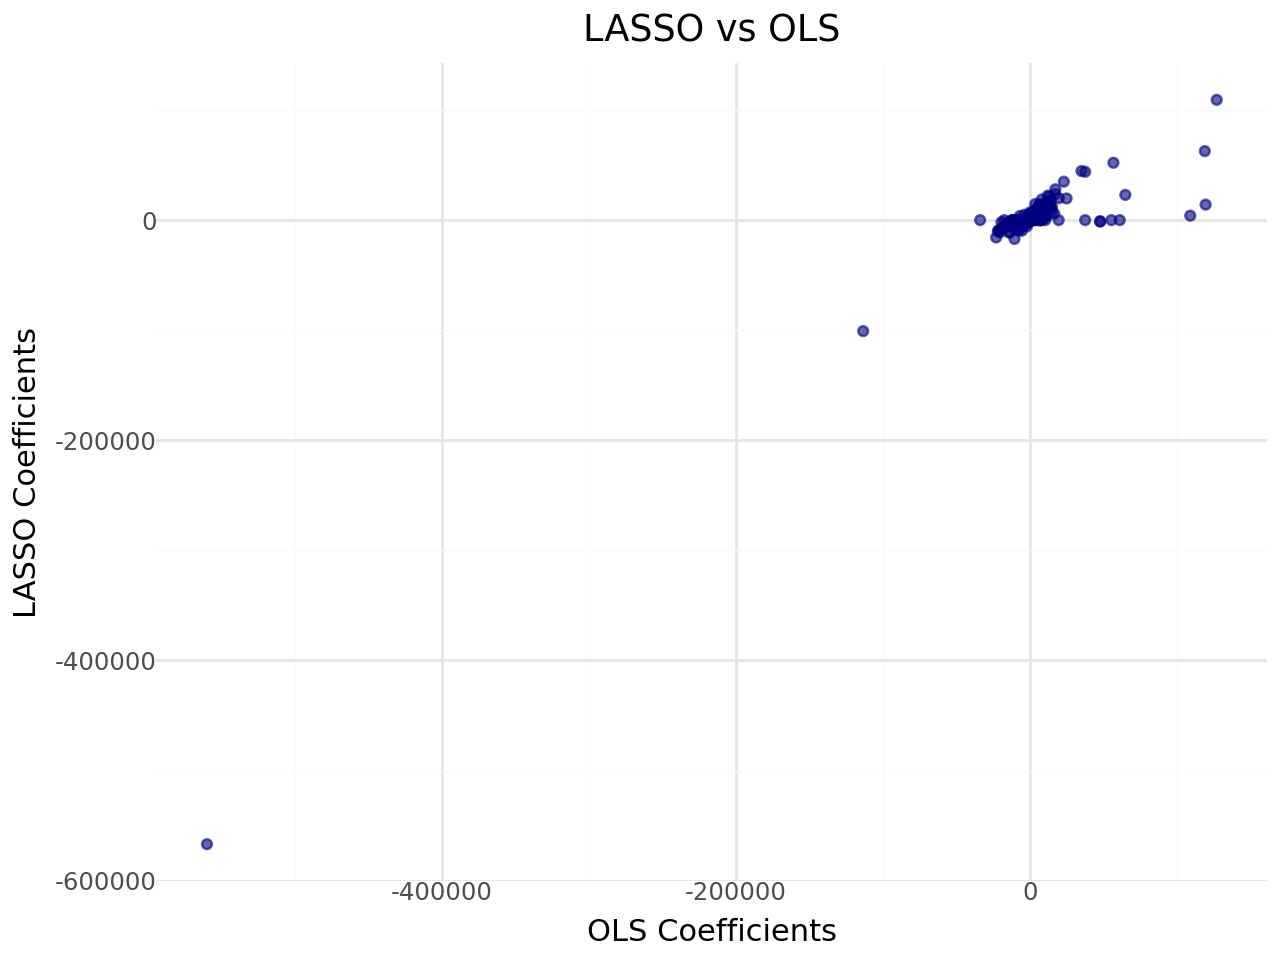

In [25]:
#activity 3

lasso_pipe = Pipeline([
    ("prep", preprocessor),
    ("lasso", Lasso(alpha=10, max_iter=50000))
])

lasso_pipe.fit(X, y)

lasso_coef = lasso_pipe.named_steps["lasso"].coef_

coef_df = pd.DataFrame({"OLS": b_ols, "LASSO": lasso_coef})

(ggplot(coef_df, aes(x="OLS", y="LASSO"))
 + geom_point(alpha=0.6, color="navy")
 + labs(title="LASSO vs OLS", x="OLS Coefficients", y="LASSO Coefficients")
 + theme_minimal())


Best λ: 0.01, Best α (l1_ratio): 0.5, RMSE: 28632.34


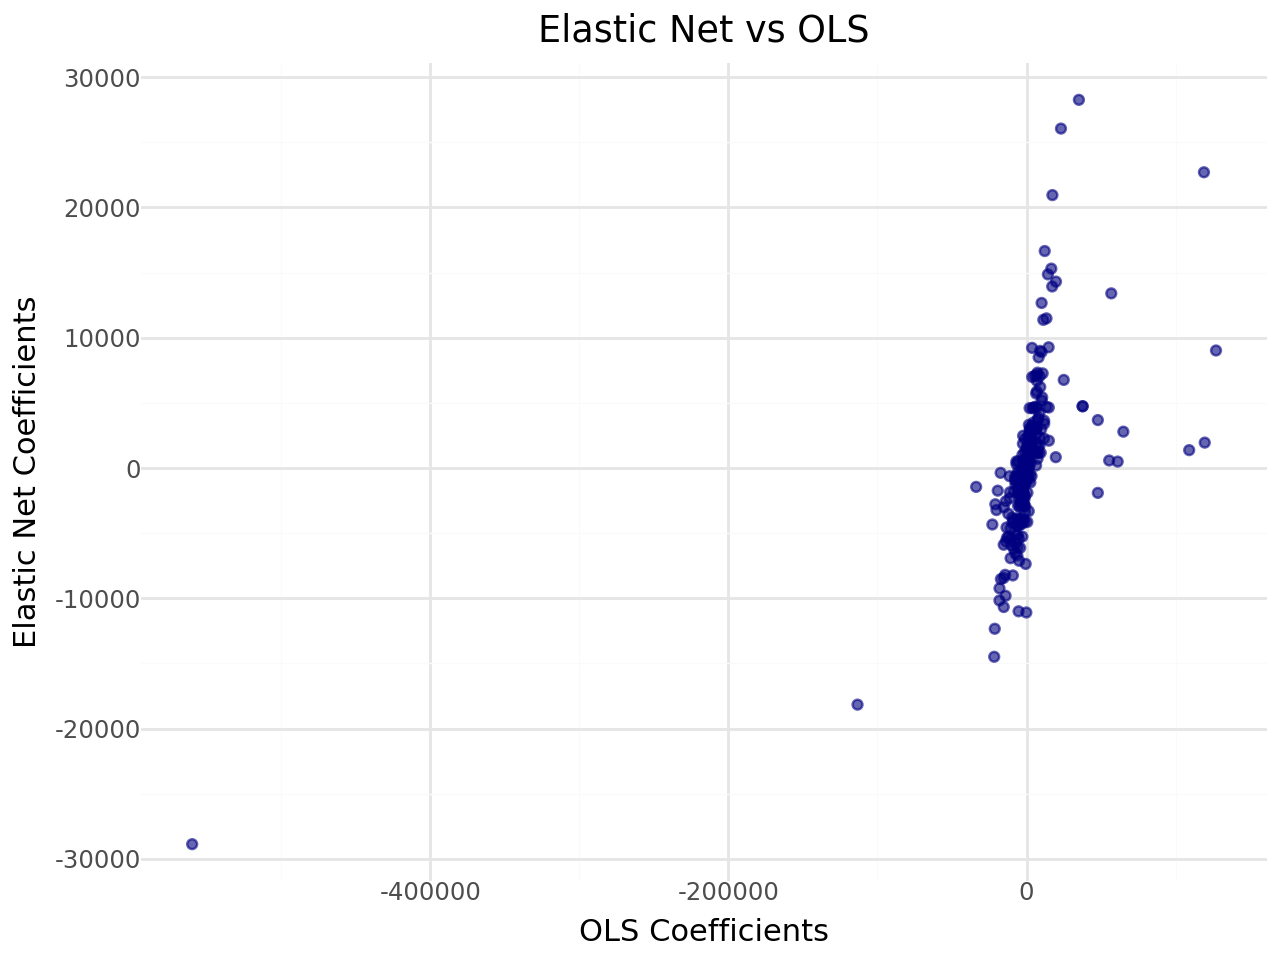

In [27]:
#activity 4 (ai helped)

elastic_pipe = Pipeline([
    ("prep", preprocessor),
    ("enet", ElasticNet(max_iter=50000))
])

alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]

scores = []
for a in alphas:
    for l1 in l1_ratios:
        elastic_pipe.set_params(enet__alpha=a, enet__l1_ratio=l1)
        rmse = (-cross_val_score(elastic_pipe, X, y, cv=5,
                                 scoring="neg_root_mean_squared_error")).mean()
        scores.append((a, l1, rmse))

best_a, best_l1, best_rmse = min(scores, key=lambda x: x[2])
print(f"Best λ: {best_a}, Best α (l1_ratio): {best_l1}, RMSE: {round(best_rmse, 2)}")

elastic_pipe.set_params(enet__alpha=best_a, enet__l1_ratio=best_l1).fit(X, y)
elastic_coef = elastic_pipe.named_steps["enet"].coef_

coef_df = pd.DataFrame({"OLS": b_ols, "ElasticNet": elastic_coef})

(ggplot(coef_df, aes(x="OLS", y="ElasticNet"))
 + geom_point(alpha=0.6, color="navy")
 + labs(title="Elastic Net vs OLS", x="OLS Coefficients", y="Elastic Net Coefficients")
 + theme_minimal())
